In [69]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, normalize
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.tree import export_text
from sklearn import set_config
from sklearn.metrics import accuracy_score, silhouette_score, f1_score, average_precision_score, recall_score
from sklearn.feature_selection import f_regression, f_classif, mutual_info_classif, chi2, SelectKBest
set_config(display='diagram')

## **Read data from UCI dataset**

In [70]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv', sep=',')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


<h4><b>Data description</b></h4>

<p>The dataset consists of 10 numerical and 8 categorical attributes.</p>
<p>The 'Revenue' attribute can be used as the class label.</p>
<p>We refer to split the data set into train set and test set with ratio 70%-30%. Test set will be kept to calculate the accuracy of the model</p>

In [71]:
df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

Below, we would refer to split the data set into train set and test set with ratio of (75%, 25%) of data set. Moreover, from the train set, we continue spliting a part of it for validation set with ratio of (75%, 25%) of train set.

In [72]:
df, test_df = train_test_split(df, test_size=0.25, random_state=0)
train_df, val_df = train_test_split(df, test_size=0.25, random_state=0)

In [73]:
print(f"Train set shape: {train_df.shape}")
print(f"Validate set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (6935, 18)
Validate set shape: (2312, 18)
Test set shape: (3083, 18)


We just `randome_state` the `train_test_split` to make the training process more efficient in general.

In [74]:
train_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
3271,7,89.900000,3,84.0,58,2787.250000,0.000000,0.007716,98.042626,0.0,May,2,2,1,2,Returning_Visitor,False,False
10384,9,137.322222,1,418.5,41,1933.244444,0.006079,0.021222,0.000000,0.0,Dec,2,2,1,2,Returning_Visitor,False,False
5126,0,0.000000,0,0.0,43,703.833333,0.000000,0.006977,0.000000,0.0,May,2,4,1,2,Returning_Visitor,False,False
6650,1,20.200000,0,0.0,77,3107.173333,0.002597,0.017042,18.748602,0.0,Sep,2,2,7,1,Returning_Visitor,False,True
11485,0,0.000000,0,0.0,30,1285.166667,0.002759,0.022660,0.000000,0.0,Nov,3,3,1,8,Returning_Visitor,True,False


In [75]:
cate_cols = train_df.columns[-8:]
nume_cols = train_df.columns.drop(cate_cols)

### Check data types

In [76]:
train_df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

The data types are the same as the dataset description.

### Deal with missing values
We check the data type of each column and whether the column has missing value

In [77]:
train_df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

<p>Well, there is no missing values to process</p>
<p>Next, we will choose the categorical and numerical columns to handle quickly.</p>

### Identify outliers

In this step, we will deal with outliers on numerical columns


In [78]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000,9247.000000
mean,2.317725,82.191815,0.499513,33.715256,31.792149,1194.550816,0.022387,0.043220,5.783374,0.061815,2.127501,2.362388,3.164161,4.094950
std,3.310203,182.657364,1.275052,140.574715,44.871329,1961.423881,0.048841,0.048798,18.258968,0.199509,0.922164,1.718090,2.411012,4.051937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,180.500000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,588.366667,0.002985,0.025421,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.000000,0.000000,0.000000,38.000000,1473.495833,0.017058,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,360.953384,1.000000,8.000000,13.000000,9.000000,20.000000


* Interquartile Range Method

In [79]:
Q1 = train_df[nume_cols].quantile(0.25)
Q3 = train_df[nume_cols].quantile(0.75)
IQR = Q3 - Q1

outlier_iqr_df = train_df[~((train_df[nume_cols] < (Q1 - 1.5 * IQR)) | (train_df[nume_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f'Percentage of outliers: {round((1-outlier_iqr_df.shape[0]/train_df.shape[0])*100, 2)}%')

Percentage of outliers: 56.41%


This method made us surprised that the outliers claim too high percentage so we need to visualize them

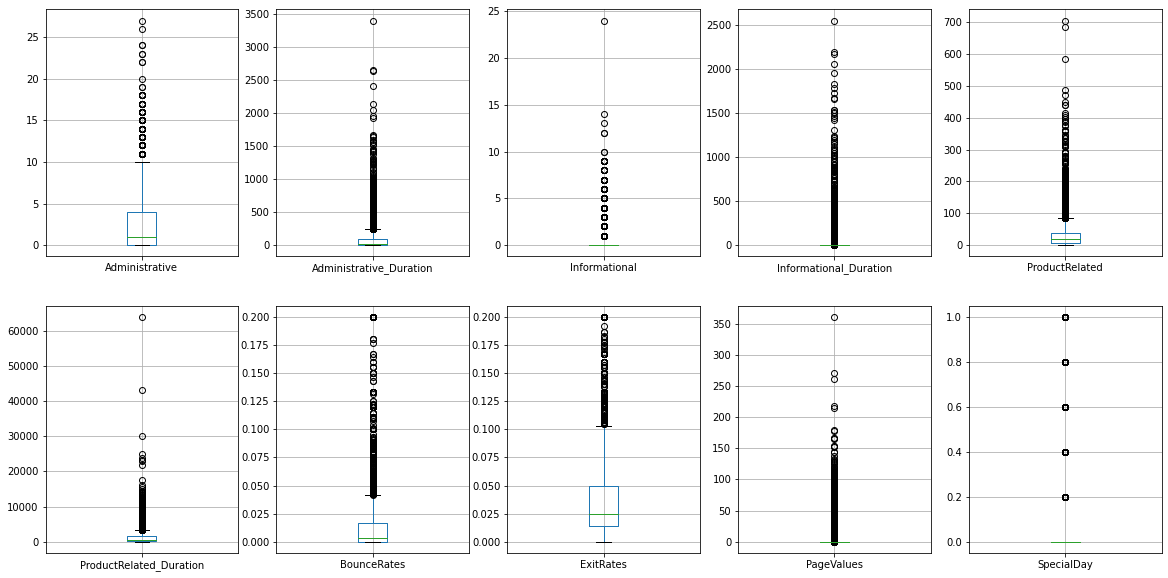

In [80]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for index in range(len(nume_cols)):
    row, col = index // 5, index % 5
    train_df.boxplot(nume_cols[index], ax = axes[row, col], fontsize=10) 
plt.show()

Looking at the graph, we can see that each numerical column has too many outliers that we can not remove because they will affect the result

* Standard deviation method

In [81]:
data_mean, data_std = np.mean(train_df[nume_cols], axis=0), np.std(train_df[nume_cols])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outlier_std_df = train_df[~((train_df[nume_cols] < lower) | (train_df[nume_cols] > upper)).any(axis=1)]
print(f'Percentage of outliers: {round((1-outlier_std_df.shape[0]/train_df.shape[0])*100, 2)}%')

Percentage of outliers: 18.59%


We wonder if the values are outliers because the percentage of the outliers is so high. We intend to use a different method to handle.

* Automatic Outlier Detection

In [82]:
lof = LocalOutlierFactor()
yhat = lof.fit_predict(train_df[nume_cols])
mask = yhat != -1
outlier_aod_df = train_df.iloc[mask]
print(f'Percentage of outliers: {round((1-outlier_aod_df.shape[0]/train_df.shape[0])*100, 2)}%')

Percentage of outliers: 9.52%


<b>We can see that there are too many outliers existed in the dataset. We wonder whether they have their own meaning and decide to disregard them.</b>

### d) Check duplicates

In [83]:
duplicates = train_df.shape[0] - train_df.drop_duplicates().shape[0]
print(f'There are {duplicates} duplicate(s) in the train set and it claims {round(duplicates*100/train_df.shape[0],2)}%')

There are 48 duplicate(s) in the train set and it claims 0.69%


The dataset contains some duplicates so we decide to remove them

In [84]:
train_df.drop_duplicates(inplace=True)

### e) Check category columns

In [85]:
for col in cate_cols:
    print(f'{col}: {train_df[col].unique()}')

Month: ['May' 'Dec' 'Sep' 'Nov' 'Mar' 'June' 'Jul' 'Oct' 'Aug' 'Feb']
OperatingSystems: [2 3 1 4 8 6 5 7]
Browser: [ 2  4  3  1  6  5 10 13  8  7 12 11  9]
Region: [1 7 6 8 4 3 9 2 5]
TrafficType: [ 2  1  8  4  6  3 13 20  5 11  7 10 15  9 14 19 12 18 16]
VisitorType: ['Returning_Visitor' 'New_Visitor' 'Other']
Weekend: [False  True]
Revenue: [False  True]


We see that the data is correct after manually checking it, so we don't need to repair it.
To make things easier, we'll encode which columns aren't number to number later.

# Task 2: Feature Engineering

Firstly, we should encode the object values to number in order to handle conveniently.

In [86]:
LE = LabelEncoder()
obj_cols = train_df.select_dtypes(['bool', 'object'])
for col in obj_cols:
    train_df[col] = LE.fit_transform(train_df[col])
train_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
3271,7,89.900000,3,84.0,58,2787.250000,0.000000,0.007716,98.042626,0.0,6,2,2,1,2,2,0,0
10384,9,137.322222,1,418.5,41,1933.244444,0.006079,0.021222,0.000000,0.0,1,2,2,1,2,2,0,0
5126,0,0.000000,0,0.0,43,703.833333,0.000000,0.006977,0.000000,0.0,6,2,4,1,2,2,0,0
6650,1,20.200000,0,0.0,77,3107.173333,0.002597,0.017042,18.748602,0.0,9,2,2,7,1,2,0,1
11485,0,0.000000,0,0.0,30,1285.166667,0.002759,0.022660,0.000000,0.0,7,3,3,1,8,2,1,0


In [87]:
best_features = SelectKBest(score_func=chi2, k=7)
X = train_df.drop(['Revenue'], axis=1)
y = train_df['Revenue']
fit = best_features.fit(X, y)
scores_df = pd.DataFrame(fit.scores_)
columns_df = pd.DataFrame(X.columns)
featureScores = pd.concat([columns_df, scores_df],axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(10, 'Score'))

                    Feature          Score
5   ProductRelated_Duration  471437.755664
8                PageValues   95348.280205
1   Administrative_Duration   30451.873728
3    Informational_Duration   15668.826600
4            ProductRelated   10431.320555
0            Administrative     635.007361
2             Informational     189.924354
10                    Month      42.441125
9                SpecialDay      32.747646
15              VisitorType      26.170121


Text(0.5, 0, 'Correlation Statistic Value')

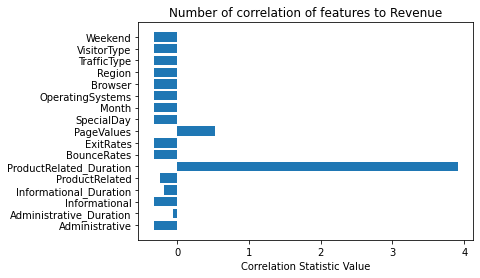

In [88]:
featureScores['Score'] = StandardScaler().fit_transform(np.array(featureScores['Score']).reshape(-1, 1))
plt.barh(featureScores['Feature'], featureScores['Score'])
plt.title('Number of correlation of features to Revenue')
plt.xlabel('Correlation Statistic Value')

<p>We assume that top 7 most correlative with Revenue column will be appropriate for the model.</p>

Firstly, we need to find two features which are less correlation. We only search on numerical 

In [89]:
train_df[nume_cols].corr()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
Administrative,1.000000,0.618297,0.383344,0.253270,0.426623,0.360867,-0.213692,-0.309551,0.123077,-0.100156
Administrative_Duration,0.618297,1.000000,0.340175,0.283132,0.325513,0.408772,-0.138423,-0.203231,0.086628,-0.070356
Informational,0.383344,0.340175,1.000000,0.602319,0.376978,0.395278,-0.105722,-0.155023,0.053558,-0.044218
Informational_Duration,0.253270,0.283132,0.602319,1.000000,0.300517,0.385874,-0.066544,-0.100396,0.029563,-0.037096
ProductRelated,0.426623,0.325513,0.376978,0.300517,1.000000,0.854527,-0.191155,-0.282544,0.058368,-0.020274
ProductRelated_Duration,0.360867,0.408772,0.395278,0.385874,0.854527,1.000000,-0.165919,-0.232471,0.047679,-0.034107
BounceRates,-0.213692,-0.138423,-0.105722,-0.066544,-0.191155,-0.165919,1.000000,0.908017,-0.119907,0.079484
ExitRates,-0.309551,-0.203231,-0.155023,-0.100396,-0.282544,-0.232471,0.908017,1.000000,-0.179053,0.109408
PageValues,0.123077,0.086628,0.053558,0.029563,0.058368,0.047679,-0.119907,-0.179053,1.000000,-0.062680
SpecialDay,-0.100156,-0.070356,-0.044218,-0.037096,-0.020274,-0.034107,0.079484,0.109408,-0.062680,1.000000


We assume that SpecialDay is ordinary data so we tend to avoid it and select `Informational_Duration` and `PageValues` columns for clustering. The silhouette score is used to evaluate the model.

In [90]:
clustering_features = ['Informational_Duration', 'PageValues']

Now from the data we start to split into X and y columns with the Revenue was the label class feature

In [91]:
train_X_df = train_df.drop(['Revenue'], axis=1)
train_y_sr = train_df['Revenue'].replace({True: 1, False: 0})
val_X_df = val_df.drop(['Revenue'], axis=1)
val_y_sr = val_df['Revenue'].replace({True: 1, False: 0})
test_X_df = test_df.drop(['Revenue'], axis=1)
test_y_sr = test_df['Revenue'].replace({True: 1, False: 0})
cate_cols = cate_cols.drop(['Revenue'])

In [92]:
class ColTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_list=[], num_top_values_list=[], default=-1):
        self.num_top_values_list = num_top_values_list
        self.columns_list = columns_list
        self.default = default

    def getLogicNumberTopValue(self, X_df, column):
        counts = X_df[column].value_counts()
        return sum([1 for value in list(counts.values) if value>(1*max(list(counts.values))/100)])

    def reprocessing_data(self, X_df):
        try:
            self.columns_list = [column for column in self.columns_list if len(X_df[column].value_counts())>=5]
            if len(self.num_top_values_list)==0:
                self.num_top_values_list = [self.getLogicNumberTopValue(X_df, column) for column in self.columns_list]
        except: 
            return
            
    def fit(self, X_df, y=None):
        self.reprocessing_data(X_df)
        self.top_values_list = []

        for column, num_top_values in zip(self.columns_list, self.num_top_values_list):
            self.counts_ = X_df[column].value_counts()
            ids = list(self.counts_.index)
            self.top_values_list.append(ids[:max(1, min(num_top_values, len(ids)))])
        return self
    
    def transform(self, X_df, y=None):
        out_df = X_df.copy()
        for top_value, column in zip(self.top_values_list, self.columns_list):
            out_df.loc[~out_df[column].isin(top_value), column] = self.default
            out_df = out_df.sort_index(axis=1)
        return out_df

In [93]:
col_transformer = ColTransformer(columns_list=cate_cols, default=0)
col_transformer.fit(train_X_df)
new_train_X_df = col_transformer.transform(train_X_df)
new_train_X_df.head()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Weekend
3271,7,89.900000,0.000000,2,0.007716,3,84.0,6,2,98.042626,58,2787.250000,1,0.0,2,2,0
10384,9,137.322222,0.006079,2,0.021222,1,418.5,1,2,0.000000,41,1933.244444,1,0.0,2,2,0
5126,0,0.000000,0.000000,4,0.006977,0,0.0,6,2,0.000000,43,703.833333,1,0.0,2,2,0
6650,1,20.200000,0.002597,2,0.017042,0,0.0,9,2,18.748602,77,3107.173333,7,0.0,1,2,0
11485,0,0.000000,0.002759,3,0.022660,0,0.0,7,3,0.000000,30,1285.166667,1,0.0,8,2,1


<p>Some category columns have too many categories that will affect the model. So, we choose which columns that have more than 5 categories to process</p>

<h3>Preprocessing Pipeline</h3>

- `Pipeline`*[2]
- `Preprocessing`: in here, input data would be treated by seperating into numeric and categorical data. After spliting, both of them would be fill up **Missing Values** with the MEAN for the numeric and MOST_FREQUENCY for categorical. In addition, categorical would be encoding by `OneHotEncoder`. Finally, `StandardScaler` will scale the value into normalizing range for modeling process*[3].

In [94]:
numerics_trans=make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean')
)
categorical_trans=make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

column_trans = make_column_transformer(
    (numerics_trans, nume_cols),
    (categorical_trans, cate_cols)
)

preprocess_pipeline = make_pipeline(
    col_transformer,
    column_trans,
    StandardScaler(with_mean=False)
)
preprocess_pipeline

Pipeline(steps=[('coltransformer',
                 ColTransformer(columns_list=['Month', 'OperatingSystems',
                                              'Browser', 'Region',
                                              'TrafficType'],
                                default=0,
                                num_top_values_list=[10, 5, 8, 9, 11])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informatio...
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'],
      dtype='object'))])),
                ('standardscaler', StandardScaler(with_mean=False))])

# Task 3: Data Modeling

<h3>1st Model: Classification using Neural Network</h3>

Problem: With the given features, detecting the crucial ones then build up modeling for the classification of these features into Revenue-Rewards

**Select the appropriate model**: Along including Preprocessing Pipeline, there are 2 more:
- `Selecting Best Features`: in this step, data would filtered in order to reduce the dimension of data by using `Chi2-Algorithms`. The number of features kept would be defined by manually or by grid search later.*[3][4]
- `MLP Classifier`: using Neural Network method, this step would start to learning through the preprocessed data and spride out the ACCURACY of this model after training.

In [95]:
full_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2, k=7)),
    ('mlpclassifier', MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', random_state=0, learning_rate_init=0.05, alpha=100, max_iter=1000))
])
full_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('coltransformer',
                                  ColTransformer(columns_list=['Month',
                                                               'OperatingSystems',
                                                               'Browser',
                                                               'Region',
                                                               'TrafficType'],
                                                 default=0,
                                                 num_top_values_list=[10, 5, 8,
                                                                      9, 11])),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer())]),
                                                                   Index(['Administrative', 'Admini...
                                                                   Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'],
      dtype='object'))])),
                                 ('standardscaler',
                                  StandardScaler(with_mean=False))])),
                ('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function chi2 at 0x000002C15E037910>)),
                ('mlpclassifier',
                 MLPClassifier(alpha=100, hidden_layer_sizes=50,
                               learning_rate_init=0.05, max_iter=1000,
                               random_state=0))])

In [96]:
full_pipeline.fit(train_X_df, train_y_sr)
train_acc = full_pipeline.score(train_X_df, train_y_sr)*100
val_acc = full_pipeline.score(val_X_df, val_y_sr)*100
print(f'With the above model pipeline we get the accuracy of train: {train_acc.round(3)} and validate: {val_acc.round(3)}')

With the above model pipeline we get the accuracy of train: 84.275 and validate: 86.981


Due to the defined paramaters of Neural Network, in which include `hidden_layer_sizes=(50), activation='relu', solver='adam', random_state=0, learning_rate_init=0.05, alpha=100, max_iter=1000`, we got the final accuracy was: **84%**

After training the model we got the accuracy is 84%, this score still be pretty unacceptable so in next we tend to innovate our current model by using grid search method

In [97]:
optimize_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2)),
    ('mlpclassifier', MLPClassifier(hidden_layer_sizes=(50), solver='adam', activation='relu', random_state=0, learning_rate_init=0.05, max_iter=1000))
])

param_grid_mlp = {'mlpclassifier__activation': ['logistic', 'relu', 'tanh'],
            'selectkbest__k': [3, 5, 7, 9, 11, 14, 'all']}

grid_search_mlp = GridSearchCV(optimize_pipeline, param_grid_mlp, verbose=True)
grid_search_mlp.fit(train_X_df, train_y_sr)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('coltransformer',
                                                         ColTransformer(columns_list=['Month',
                                                                                      'OperatingSystems',
                                                                                      'Browser',
                                                                                      'Region',
                                                                                      'TrafficType'],
                                                                        default=0,
                                                                        num_top_values_list=[10,
                                                                                             5,
                                                                                             8,
                                                                                             9,
                                                                                             11])),
                                                        ('columntransformer',
                                                         ColumnTransformer(transformers=[('pipeline-1',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer())]),
                                                                                          Index(['...
                                                        ('standardscaler',
                                                         StandardScaler(with_mean=False))])),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function chi2 at 0x000002C15E037910>)),
                                       ('mlpclassifier',
                                        MLPClassifier(hidden_layer_sizes=50,
                                                      learning_rate_init=0.05,
                                                      max_iter=1000,
                                                      random_state=0))]),
             param_grid={'mlpclassifier__activation': ['logistic', 'relu',
                                                       'tanh'],
                         'selectkbest__k': [3, 5, 7, 9, 11, 14, 'all']},
             verbose=True)

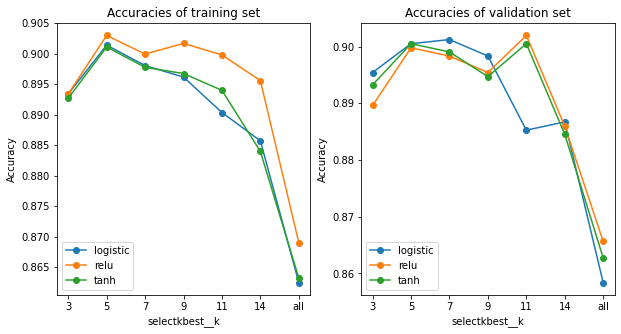

In [98]:
def plot_grid_search(grid_search, grid_params, attribute='mean_test_score', title='None'):
    scores = np.array(grid_search.cv_results_[attribute]).reshape(len(grid_params[list(grid_params.keys())[0]]), len(grid_params[list(grid_params.keys())[1]]))
    for score, param in zip(scores, grid_params[list(grid_params.keys())[0]]):
        plt.plot(grid_params[list(grid_params.keys())[1]], score, '-o', label=param)
    plt.legend(loc='lower left')
    plt.xlabel(list(grid_params.keys())[1])
    plt.ylabel('Accuracy')
    plt.title(title)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plot_grid_search(grid_search_mlp, param_grid_mlp, title='Accuracies of training set')
plt.subplot(1, 2, 2)
plot_grid_search(grid_search_mlp, param_grid_mlp, attribute='split3_test_score', title='Accuracies of validation set')

After using grid search for innovating model, we defined that the best activation was RELU and the number of features should be kept was 5 features. In which the accuracy was converging at **90.9%**

In [113]:
val_acc = grid_search_mlp.score(val_X_df, val_y_sr)*100
final_score = accuracy_score(grid_search_mlp.predict(test_X_df), test_y_sr, normalize=True)*100
print(f'With the grid searching, we found a better validate accuracy for the model with {val_acc.round(3)}%')
print(f'In conclusion, along with paramas of {grid_search_mlp.best_params_} we get the final test score in model be {final_score.round(3)}% in practical')

With the grid searching, we found a better validate accuracy for the model with 91.263%
In conclusion, along with paramas of {'mlpclassifier__activation': 'relu', 'selectkbest__k': 5} we get the final test score in model be 88.615% in practical


<h3>2nd Model: Classification using decision tree</h3>

Pipline architecture: Along including Preprocessing Pipeline, there are 2 more:
- `Selecting Best Features`: in this step, data would filtered in order to reduce the dimension of data by using `Chi2-Algorithms`. The number of features kept would be defined by manually or by grid search later.
- `DecisionTreeClassifier`: using Decision Tree method for classifying data into TRUE and FALSE in the Revenue.

In [100]:
tree_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2, k=10)),
    ('decisiontree', DecisionTreeClassifier(random_state=0, max_depth=10))
])
tree_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('coltransformer',
                                  ColTransformer(columns_list=['Month',
                                                               'OperatingSystems',
                                                               'Browser',
                                                               'Region',
                                                               'TrafficType'],
                                                 default=0,
                                                 num_top_values_list=[10, 5, 8,
                                                                      9, 11])),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer())]),
                                                                   Index(['Administrative', 'Admini...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'],
      dtype='object'))])),
                                 ('standardscaler',
                                  StandardScaler(with_mean=False))])),
                ('selectkbest',
                 SelectKBest(score_func=<function chi2 at 0x000002C15E037910>)),
                ('decisiontree',
                 DecisionTreeClassifier(max_depth=10, random_state=0))])

In [101]:
tree_pipeline.fit(train_X_df, train_y_sr)
val_score = tree_pipeline.score(val_X_df, val_y_sr)*100
train_score = tree_pipeline.score(train_X_df, train_y_sr)*100
print(f'Train accuracy: {train_score}, Validation accuracy: {val_score}')

Train accuracy: 95.86176854944097, Validation accuracy: 90.44117647058823


From the defined parameters of decision model, which including `max_depth` is 10 and `number of k feautre kept` is 7, we receive ACCURACY is **96%** for train and **90%** for validation, which is quite overfit on train.

In [102]:
optimize_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2, k=7)),
    ('decisiontree', DecisionTreeClassifier(random_state=0))
])

param_grid_tree = {'decisiontree__min_samples_split': [2, 5, 7, 10, 14, 16],
                'decisiontree__max_depth': [5, 8, 10, 12, 15, 17]}

grid_search_tree = GridSearchCV(tree_pipeline, param_grid_tree, verbose=True)
grid_search_tree.fit(train_X_df, train_y_sr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('coltransformer',
                                                         ColTransformer(columns_list=['Month',
                                                                                      'OperatingSystems',
                                                                                      'Browser',
                                                                                      'Region',
                                                                                      'TrafficType'],
                                                                        default=0,
                                                                        num_top_values_list=[10,
                                                                                             5,
                                                                                             8,
                                                                                             9,
                                                                                             11])),
                                                        ('columntransformer',
                                                         ColumnTransformer(transformers=[('pipeline-1',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer())]),
                                                                                          Index(['...
       'VisitorType', 'Weekend'],
      dtype='object'))])),
                                                        ('standardscaler',
                                                         StandardScaler(with_mean=False))])),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function chi2 at 0x000002C15E037910>)),
                                       ('decisiontree',
                                        DecisionTreeClassifier(max_depth=10,
                                                               random_state=0))]),
             param_grid={'decisiontree__max_depth': [5, 8, 10, 12, 15, 17],
                         'decisiontree__min_samples_split': [2, 5, 7, 10, 14,
                                                             16]},
             verbose=True)

In [115]:
val_score = grid_search_tree.score(val_X_df, val_y_sr)*100
train_score = grid_search_tree.score(train_X_df, train_y_sr)*100
print(f'Traininig accuracy: {train_score}')
print(f'Validation accuracy: {val_score}')

Traininig accuracy: 91.1427326847684
Validation accuracy: 90.52768166089965


After grid searching in the fields of `min sample split` and `max depth`, we figure out the new better ACCURACY was ~ **91%** for **BOTH** train and val, adress the problem of overfit above.

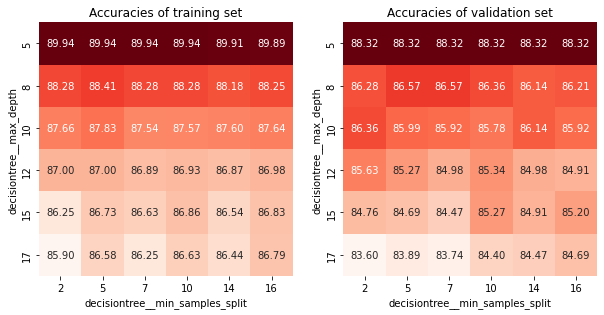

In [104]:
def plot_grid_search_heatmap(grid_search, grid_params, attribute='mean_test_score', title='None'):
    scores = np.array(grid_search.cv_results_[attribute]*100).reshape(6,6)
    df_heatmap = pd.DataFrame(scores, columns=grid_params[list(grid_params.keys())[0]], index=param_grid_tree[list(param_grid_tree.keys())[1]])
    sns.heatmap(df_heatmap, square=True, annot=True, cbar=False, fmt='.2f', cmap='Reds')
    plt.title(title)
    plt.xlabel(list(grid_params.keys())[0])
    plt.ylabel(list(grid_params.keys())[1])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
plot_grid_search_heatmap(grid_search_tree, param_grid_tree, title='Accuracies of training set')
plt.subplot(1, 2, 2)
plot_grid_search_heatmap(grid_search_tree, param_grid_tree, attribute='split0_test_score', title='Accuracies of validation set')

After grid searching, we obtain tables heatmap of training and validate accuracies. From the heatmap, it is clear that with the depth of 5 and only 2 for minimum sample split could result in a better accuracy. In which, the train and validate accuracies are quite approximating, the overfit problem has been solved with a final score ~91%. *[6]

In [105]:
test_acc = accuracy_score(grid_search_tree.predict(test_X_df), test_y_sr)*100
print(f'Appying above model for the final test set and we get the accuracy: {test_acc.round(2)}%')

Appying above model for the final test set and we get the accuracy: 87.87%


### Comparing and Recommendation

After building up models of classification, using MLBClassifier and DecisionTreeClassifier, we have to conclude that this type of data is more suitable with the later model. Particularly, due to the small number of features and small number of samples, Decision takes less time for modeling the functions although it leads to a nearly same accuracy with MLBClassifier.

In [116]:
tree_recall = recall_score(grid_search_tree.predict(test_X_df), test_y_sr)*100
tree_precision = average_precision_score(grid_search_tree.predict(test_X_df), test_y_sr)*100
print(f'The precision of Tree is {tree_precision.round(3)} and recall is {tree_recall.round(3)}')

The precision of Tree is 38.211 and recall is 70.492


In [107]:
mlp_recall = recall_score(grid_search_mlp.predict(test_X_df), test_y_sr)*100
mlp_precision = average_precision_score(grid_search_mlp.predict(test_X_df), test_y_sr)*100
print(f'The precision of Tree is {mlp_precision.round(3)} and recall is {mlp_recall.round(3)}')

The precision of Tree is 39.896 and recall is 75.072


In contrast, a model with high precision but low recall produces very few results, yet most of its projected labels match the training labels. A perfect system with great precision and recall will provide a large number of outcomes, all of which will be correctly categorized.

### 3rd Model: Clustering using K-Means

Problem: From here, we will use Clustering model for defined each group of customer segment in particular features *[7][9] <br>
With the selected features above, we will handle on `Informational_Duration` and `PageValues`

<AxesSubplot:xlabel='Informational_Duration', ylabel='PageValues'>

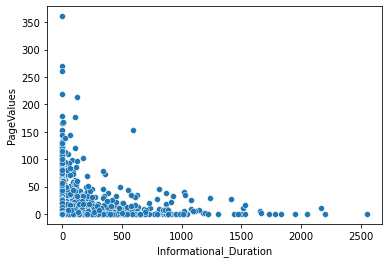

In [108]:
clustering_features = ['Informational_Duration', 'PageValues']
sns.scatterplot(data=train_df, x='Informational_Duration', y='PageValues')

In [172]:
matrix = train_X_df[['Informational_Duration', 'PageValues']].copy()
matrix_test = test_X_df[['Informational_Duration', 'PageValues']].copy()
test_scores = []
train_scores = []
clusters_size, init_size = range(2, 8), range(2, 12, 2)
for n_clusters in clusters_size:
    best_score, best_init = 0 , 0
    for n_init in init_size:
        kmeans = KMeans(n_clusters = n_clusters, n_init=n_init)
        kmeans.fit(matrix)
        silhouette_avg = silhouette_score(matrix_test, kmeans.predict(matrix_test))*100
        train_avg =  silhouette_score(matrix, kmeans.predict(matrix))*100
        test_scores.append(silhouette_avg)
        train_scores.append(train_avg)
        if (silhouette_avg>best_score):
            best_score, best_init = silhouette_avg, n_init
    print(f'For n_clusters = {n_clusters}, and n_init = {best_init}, the average silhouette_score is: {round(silhouette_avg, 5)}')

For n_clusters = 2, and n_init = 2, the average silhouette_score is: 92.82834
For n_clusters = 3, and n_init = 2, the average silhouette_score is: 89.40618
For n_clusters = 4, and n_init = 8, the average silhouette_score is: 88.24454
For n_clusters = 5, and n_init = 2, the average silhouette_score is: 84.76031
For n_clusters = 6, and n_init = 4, the average silhouette_score is: 81.35599
For n_clusters = 7, and n_init = 2, the average silhouette_score is: 79.76115


Text(373.36363636363626, 0.5, 'Number of init')

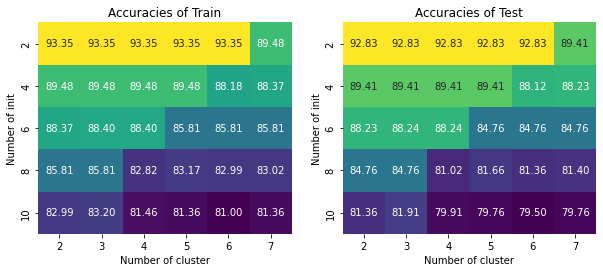

In [173]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
scores = np.array(train_scores).reshape(len(init_size), len(clusters_size))
df_heatmap = pd.DataFrame(scores, columns=clusters_size, index=init_size)
sns.heatmap(df_heatmap, square=True, annot=True, cbar=False, fmt='.2f', cmap='viridis')
plt.title('Accuracies of Train')
plt.xlabel('Number of cluster')
plt.ylabel('Number of init')

plt.subplot(1, 2, 2) 
scores = np.array(test_scores).reshape(len(init_size), len(clusters_size))
df_heatmap = pd.DataFrame(scores, columns=clusters_size, index=init_size)
sns.heatmap(df_heatmap, square=True, annot=True, cbar=False, fmt='.2f', cmap='viridis')
plt.title('Accuracies of Test')
plt.xlabel('Number of cluster')
plt.ylabel('Number of init')

The higher average silhouette_score, the more efficient clustering. To verify this, we create the scatter plot showing labelled data points*[8]

<AxesSubplot:xlabel='Informational_Duration', ylabel='PageValues'>

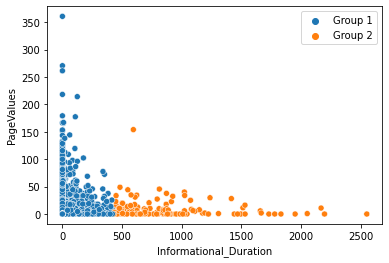

In [174]:
kmeans = KMeans(n_clusters=2, n_init=2)
kmeans.fit(matrix)
label = kmeans.predict(matrix)
label = ['Group 2' if val==1 else 'Group 1' for val in label]
sns.scatterplot(data=matrix, x='Informational_Duration', y='PageValues', hue=label)

### 4th Model: Clustering using Hierarchical

In [190]:
matrix = train_X_df[['Informational_Duration', 'PageValues']].copy()
for n_clusters in range(2,8):
    model = AgglomerativeClustering(n_clusters = n_clusters)
    clusters = model.fit_predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)*100
    print(f'For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg.round(3)}')

For n_clusters = 2, the average silhouette_score is : 0.94
For n_clusters = 3, the average silhouette_score is : 0.885
For n_clusters = 4, the average silhouette_score is : 0.887
For n_clusters = 5, the average silhouette_score is : 0.822
For n_clusters = 6, the average silhouette_score is : 0.826
For n_clusters = 7, the average silhouette_score is : 0.827


The highest score is at n_clusters = 2 too, we need to visualize so as to have a better view

<AxesSubplot:xlabel='Informational_Duration', ylabel='PageValues'>

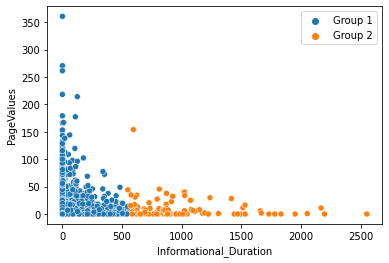

In [112]:
model = AgglomerativeClustering(n_clusters=2)
label = model.fit_predict(matrix)
label = ['Group 2' if val==1 else 'Group 1' for val in label]
sns.scatterplot(data=matrix, x='Informational_Duration', y='PageValues', hue=label)

It can be seen clearly in the above 2 figures that each cluster is well apart from each other. There are 2 main customer segments in this part:
- First one is the customers who have less belief in the Information Page and have a tendency to research more information about the products but finally lead to the not to buy answer. 

- Instead of that, the part of users who tend to stay in the shopping website after it is derived from the Information page, have more of their belief in the products and tend to pay for it.

### Comparision and Recommendation

Overall, it can be seen clearly in the above 2 figures that each cluster is well apart from each other. There are 2 main customer segments in this part:
- First one is the customers who have less belief in the Information Page and have a tendency to research more information about the products but finally lead to the not to buy answer. 

- Instead of that, the part of users who tend to stay in the shopping website after it is derived from the Information page, have more of their belief in the products and tend to pay for it.

K-means requires the clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes so we recommend using `Hierarchical clustering` which has more options to handle

# References

[1] Statistic Correlation: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[2] Transform Target: https://scikit-learn.org/stable/modules/compose.html#transforming-target-in-regression <br>
[3] Scaling Method: https://ndquy.github.io/posts/cac-phuong-phap-scaling/ <br>
[4] Wiki_Chi2: https://en.wikipedia.org/wiki/Chi-squared_test <br>
[5] Wiki_PersonalChi2: https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test <br>
[6] Overfitting Confronting: https://towardsdatascience.com/3-techniques-to-avoid-overfitting-of-decision-trees-1e7d3d985a09<br>
[7] Unsuppervised Learning Research: https://towardsdatascience.com/unsupervised-learning-and-data-clustering-eeecb78b422a <br>
[8] Clustering Coefficient: https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c <br>
[9] KMean Clustering: https://towardsdatascience.com/kmeans-clustering-for-classification-74b992405d0a <br>